## Machine Learning Nanodegree - Capstone Project
### Who is in the photo?
The proposal of this project is to build a model that allow to recognize persons in the image using Deep Learning. 
In this notebook, I will tests 3 architectures of CNN:

* VGG16 with transfer learning 
* ResNet50 with transfer learning
* A custom architecture


### First, Load and Clean up the dataset 

In [6]:
%matplotlib inline

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import cv2


def load_face_dataset(path):
    data = load_files(path)
    general_targets = data['target']
    face_files = np.array(data['filenames'])
    face_targets = np_utils.to_categorical(np.array(data['target']), 83)
    return face_files, face_targets

train_files, train_targets = load_face_dataset('../faces/train')
valid_files, valid_targets = load_face_dataset('../faces/valid')
test_files, test_targets = load_face_dataset('../faces/test')

person_names = [item[15:-1] for item in sorted(glob("../faces/train/*/"))]

print(str(len(train_files)))
print('There are %d total person names.' % len(person_names))
print('There are %s total face images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training face images.' % len(train_files))
print('There are %d validation face images.' % len(valid_files))
print('There are %d test face images.'% len(test_files))

11071
There are 83 total person names.
There are 13823 total face images.

There are 11071 training face images.
There are 1364 validation face images.
There are 1388 test face images.


In [110]:
from keras.preprocessing import image                  
from tqdm import tqdm
import face_recognition

haar_cascade_path = '/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml'
detector= cv2.CascadeClassifier(haar_cascade_path);

def extract_face(img):
    img = img.astype(np.uint8)
    faces = detector.detectMultiScale(img)
    if len(faces)> 0:
        x,y,w,h =  faces[0]
        img = img[y:y+h,x:x+w]
        img = image.array_to_img(img)
        img = img.resize((100,100))
        img = image.img_to_array(img)
        return img
    return []


def path_to_tensor(img_path, target_size=(100,100), extract_faces=False):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=target_size, grayscale=False)
    img = image.img_to_array(img)
    face = extract_face(img)
    if len(face) == 0:
        x = image.img_to_array(img)
        return np.expand_dims(x, axis=0)    
#     x = image.img_to_array(img)
    return np.expand_dims(face, axis=0)

def paths_to_tensor(img_paths, target_size=(100,100)):
    #list_of_tensors = [path_to_tensor(img_path, target_size) for img_path in tqdm(img_paths)]
    list_of_tensors = []
    for img_path in tqdm(img_paths):
        tensor = path_to_tensor(img_path, target_size)
        if len(tensor) > 0:
            list_of_tensors.append(tensor)
    return np.vstack(list_of_tensors)

#### Convert image to array

In [111]:
import cv2
from scipy.misc import imread
from scipy.misc import imresize
from tqdm import tqdm

def load_image_from(img_path):
    img = cv2.imread(img_path)
#    img = cv2.resize(img,(100,100))
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def load_images_from(img_paths):
    images = [load_image_from(path) for path in tqdm(img_paths)]
    return np.array(images)

#### Load data to train, test and validate

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255



 98%|█████████▊| 10871/11071 [01:04<00:01, 169.43it/s]

11071
10709
(array([45]),)
Julia Stiles
(100, 100, 3)


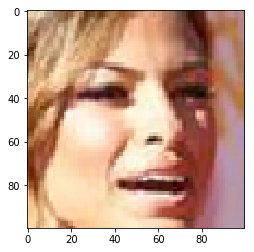

In [109]:
import matplotlib.pyplot as plt         
print(len(train_targets))
print(len(train_tensors))
index = np.where(train_targets[1] ==1)
print index
print person_names[45]
img = train_tensors[1]
print(img.shape)
plt.imshow(img)
plt.show()

## Deep Learning Models

I will use Convolutional Networks for the Deep Learning Models. In this section, I will starting checking some CNN Architectures, starting with VGG16.

#### Create some utitlity functions to visualize the performance of the models

In [24]:
def visualize_loss(xc, train_loss, validation_loss):
    plt.figure(1,figsize=(7,5))
    plt.plot(xc, train_loss)
    plt.plot(xc, validation_loss)
    plt.xlabel('num of epochs')
    plt.ylabel('loss')
    plt.title('Train Loss vs Validation Loss')
    plt.grid(True)
    plt.legend(['train', 'validation'])
    plt.style.use(['ggplot'])
    plt.show()


In [25]:
def visualize_acc(xc, train_acc, validation_acc):
    plt.figure(1,figsize=(7,5))
    plt.plot(xc, train_acc)
    plt.plot(xc, validation_acc)
    plt.xlabel('num of epochs')
    plt.ylabel('loss')
    plt.title('Train Accuracy vs Validation Accuracy')
    plt.grid(True)
    plt.legend(['train', 'validation'])
    plt.style.use(['ggplot'])
    plt.show()

In [26]:
from keras import backend as K

def get_featuresmaps(model, layer_index, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer_index].output,])
    activations = get_activations([X_batch, 0])
    return activations

In [27]:
def visualize_layer(model,image,layer_num=1, filter_num=1):
    activations = get_featuresmaps(model, int(layer_num), image)
    feature_maps = activations[0][0]
    fit = plt.figure(figsize=(5,5))
    plt.imshow(feature_maps[:,:, filter_num], cmap='gray')
    plt.savefig("featuremaps-layer-{}".format(layer_num)+"-filternum-{}".format(filter_num)+".jpg")
    
    num_of_featuremaps=feature_maps.shape[2]
    fig = plt.figure(figsize=(16,16))
    plt.title("featuremaps-layer-{}".format(layer_num))
    subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
    for i in range(int(num_of_featuremaps)):
        ax = fig.add_subplot(subplot_num, subplot_num, i+1)
        ax.imshow(feature_maps[:,:,i], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()
    fig.savefig('featuremaps-layer-{}'.format(layer_num)+'.jpg')

In [28]:
def show_predictions(test_image, model):
    predictions = model.predict(test_image)
    index = np.where(predictions==1)

    index = index[1][0]
    return person_names[index]


In [29]:
def compare_prediction(test_image, prediction_class):
    img = test_image
    plt.imshow(img)
    plt.show()
    
    validation_image = None
    for test_file in test_files:
        if prediction_class in test_file:
            validation_image = test_file
            break
    
    print(validation_image)
    if validation_image:
        validation_image = cv2.imread(validation_image) 
        plt.imshow(validation_image)
        plt.show()

### VGG16s

The origin of VGG architecture was a paper written by Simonyan and Zisserman in 2014 called: Very Deep Convolutional Networks for Large Scale Image Recognition [http://www.image-net.org/challenges/LSVRC/]

This network is characterized by its simplicity, using only 3×3 convolutional layers stacked on top of each other in increasing depth. Reducing volume size is handled by max pooling. Two fully-connected layers, each with 4,096 nodes are then followed by a softmax classifier 

In [94]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,Dropout, Flatten, Dense


In [95]:
vgg16_model = VGG16(input_tensor=Input(shape=(100,100,3)),include_top=False,weights='imagenet')
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [96]:
last_layer = vgg16_model.get_layer('block5_pool').output
custom_layer = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Dropout(0.5)(custom_layer)
custom_layer = Flatten()(custom_layer)
custom_layer = Dense(100, activation='relu')(custom_layer)
output = Dense(83, activation='softmax')(custom_layer)

# custom_layer = Flatten()(last_layer)
# custom_layer = Dense(128, activation='relu')(custom_layer)
# custom_layer = Dense(128, activation='relu')(custom_layer)
# output = Dense(16, activation='softmax')(custom_layer)
custom_vgg16_model = Model(vgg16_model.input, output)
custom_vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [97]:
from keras.optimizers import SGD

custom_vgg16_model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.005), metrics=['accuracy'])

In [98]:
from keras.callbacks import ModelCheckpoint  
from time import time
epochs =70

checkpointer = ModelCheckpoint(filepath='saved_models/custom_vgg16_weights.custom.model.hdf5', 
                               verbose=1, save_best_only=True)

# to debug on tensorboard uncomment this line and put tensoboard on model callback
# tensorboard = TensorBoard(log_dir="logs/vgg16_{}".format(time()),write_images=True,write_grads=True)

trainning_result = custom_vgg16_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)

Train on 11071 samples, validate on 1364 samples
Epoch 1/70


KeyboardInterrupt: 

#### Load VGG16 weights trained on a GPU machine

In [99]:
custom_vgg16_model.load_weights('saved_models/custom_vgg16_weights.custom.model.hdf5')

In [100]:
scores = custom_vgg16_model.evaluate(test_tensors, test_targets, batch_size=10)

print(scores)

1388/1388 [==============================] - 218s   
[0.65097487194413117, 0.85230547138181134]


### Testing the model

In [146]:
test_image_tensor = path_to_tensor('../obama.jpeg')
test_image = cv2.imread('../obama.jpeg')
print (test_image_tensor.shape)

(1, 100, 100, 3)


Morgan Freeman


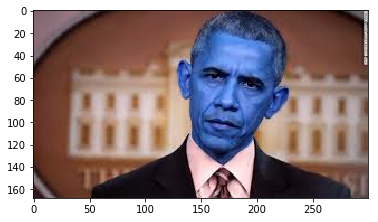

../faces/test/Morgan Freeman/100.jpg


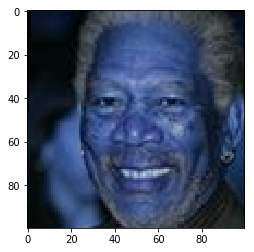

In [147]:
prediction_class = show_predictions(test_image_tensor, custom_vgg16_model)
print(prediction_class)

compare_prediction(test_image, prediction_class)


#### Visualizing the layers

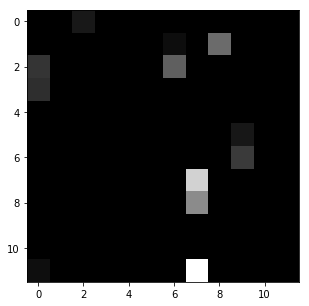

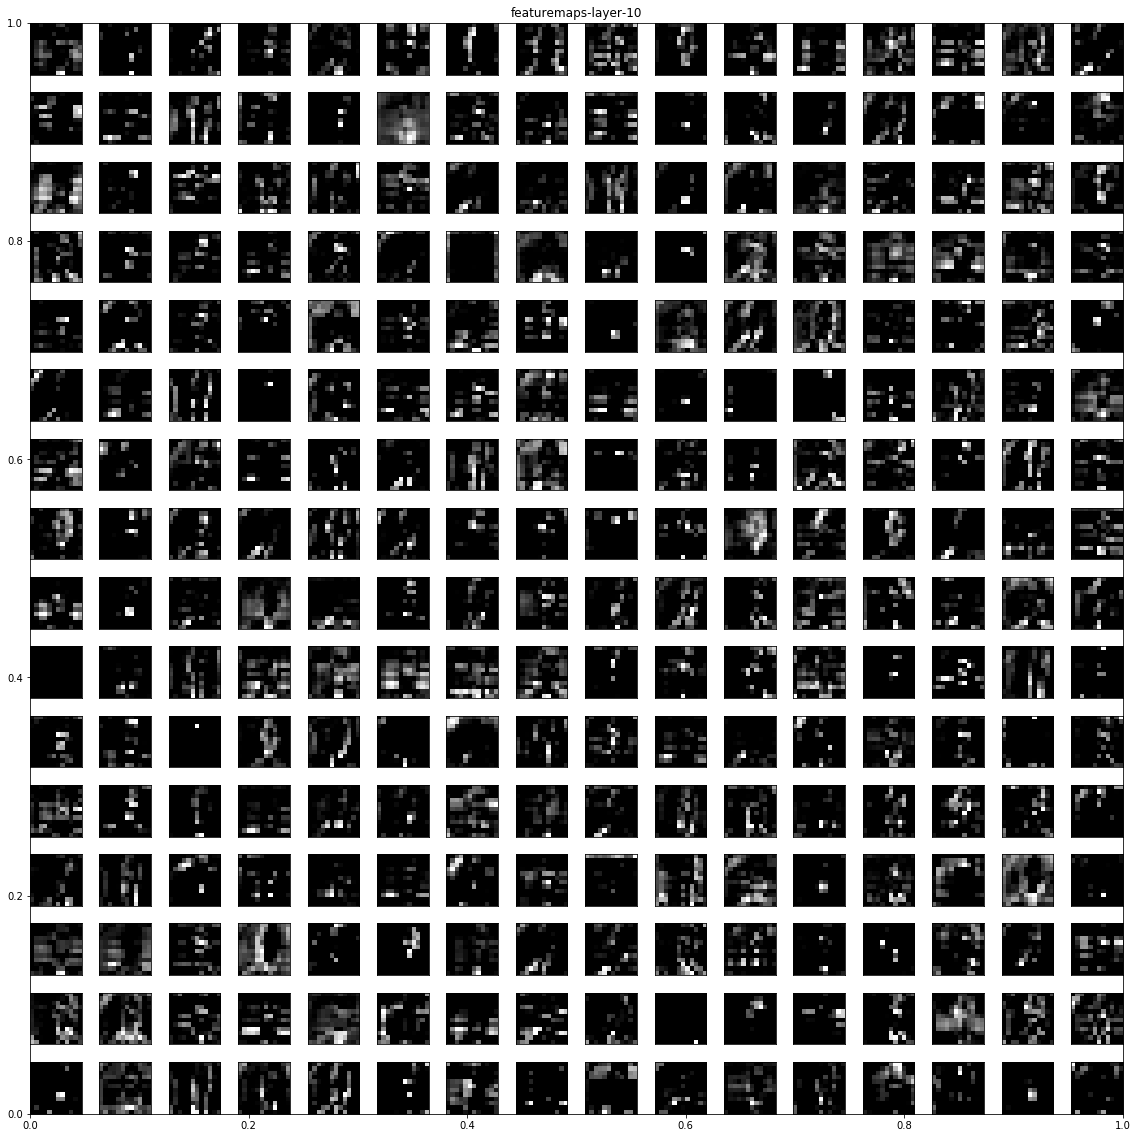

In [149]:
visualize_layer(custom_vgg16_model, test_image_tensor, layer_num=10)

### ResNet50

ResNet is a short name for Residual Network. As the name of the network indicates, the new terminology that this network introduces is residual learning.

What is Residual Learning?

In general, in a deep convolutional neural network, several layers are stacked and are trained to the task at hand. The network learns several low/mid/high level features at the end of its layers. In residual learning, instead of trying to learn some features, we try to learn some residual. Residual can be simply understood as subtraction of feature learned from input of that layer. ResNet does this using shortcut connections (directly connecting input of nth layer to some (n+x)th layer. It has proved that training this form of networks is easier than training simple deep convolutional neural networks and also the problem of degrading accuracy is resolved.

This is the fundamental concept of ResNet.

ResNet50 is a 50 layer Residual Network. There are other variants like ResNet101 and ResNet152 also.

Definition extracted from this Quora anwer: https://www.quora.com/What-is-the-deep-neural-network-known-as-%E2%80%9CResNet-50%E2%80%9D

The paper original can be found here: https://arxiv.org/abs/1512.03385


#### Resize images to 224 x 224

In [119]:
from keras.applications.resnet50 import ResNet50
# pre-process the data for Keras
train_tensors_224 = paths_to_tensor(train_files,target_size=(224,224)).astype('float32')/255
valid_tensors_224 = paths_to_tensor(valid_files,target_size=(224,224)).astype('float32')/255
test_tensors_224 = paths_to_tensor(test_files,target_size=(224,224)).astype('float32')/255

train_tensors_224 = train_tensors_224.reshape(train_tensors_224.shape[0], 224, 224, 3)
valid_tensors_224 = valid_tensors_224.reshape(valid_tensors_224.shape[0], 224, 224, 3)
test_tensors_224 = test_tensors_224.reshape(test_tensors_224.shape[0], 224, 224, 3)

100%|██████████| 1388/1388 [00:01<00:00, 1360.99it/s]


In [120]:
resnet_model = ResNet50(input_tensor=Input(shape=(224,224,3)), include_top=False, weights='imagenet')
resnet_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_3[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [121]:
from keras.layers import GlobalAveragePooling2D

last_layer = resnet_model.get_layer('avg_pool').output

custom_layer = Conv2D(filters=32, kernel_size=4, padding='same', activation='relu')(last_layer)
# custom_layer = Conv2D(filters=64, kernel_size=4, padding='same', activation='relu')(custom_layer)
# custom_layer = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(custom_layer)

custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=64, kernel_size=4, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=128, kernel_size=4, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=256, kernel_size=4, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

# custom_layer = Conv2D(filters=512, kernel_size=4, padding='same', activation='relu')(last_layer)
# custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Dropout(0.5)(custom_layer)

custom_layer = Flatten()(custom_layer)
custom_layer = Dense(224, activation='relu')(custom_layer)
out = Dense(83, activation='softmax')(custom_layer)

custom_restnet_model = Model(resnet_model.input, out)
custom_restnet_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_3[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

activation_46 (Activation)       (None, 7, 7, 2048)    0           add_15[0][0]                     
____________________________________________________________________________________________________
res5c_branch2a (Conv2D)          (None, 7, 7, 512)     1049088     activation_46[0][0]              
____________________________________________________________________________________________________
bn5c_branch2a (BatchNormalizatio (None, 7, 7, 512)     2048        res5c_branch2a[0][0]             
____________________________________________________________________________________________________
activation_47 (Activation)       (None, 7, 7, 512)     0           bn5c_branch2a[0][0]              
____________________________________________________________________________________________________
res5c_branch2b (Conv2D)          (None, 7, 7, 512)     2359808     activation_47[0][0]              
___________________________________________________________________________________________

In [122]:
custom_restnet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 70

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/custom_resnet50_weights.custom.model.hdf5', 
                               verbose=1, save_best_only=True)

tensor = TensorBoard(log_dir="logs/resnet_{}".format(time()),write_images=True,write_grads=True)

trainning_result = custom_restnet_model.fit(train_tensors_224, train_targets, 
          validation_data=(valid_tensors_224, valid_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer,tensor], verbose=1)

#### Load ResNet50 weights trained on a GPU machine

In [123]:
custom_restnet_model.load_weights('saved_models/custom_resnet50_weights.custom.model.hdf5')


In [124]:
scores = custom_restnet_model.evaluate(test_tensors_224, test_targets, batch_size=10)

print(scores)

1388/1388 [==============================] - 571s   
[2.3394022601997473, 0.42291066972726704]


#### Testing the model

In [141]:
test_image_tensor = path_to_tensor('../obama.jpeg', target_size=(224,224))
test_image = cv2.imread('../obama.jpeg')
print (test_image_tensor.shape)

(1, 224, 224, 3)


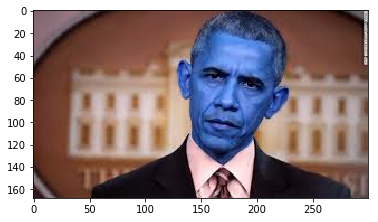

../faces/test/Daniel Radcliffe/666.jpg


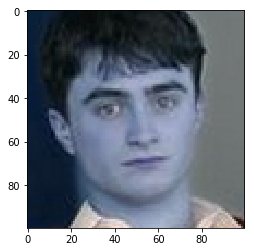

In [142]:
prediction_class = show_predictions(test_image_tensor, custom_restnet_model)
compare_prediction(test_image, prediction_class)

#### Visualizing the layers

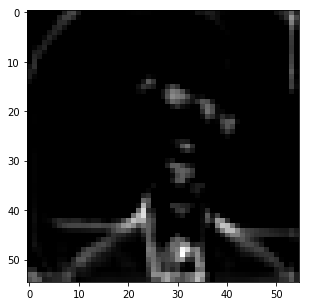

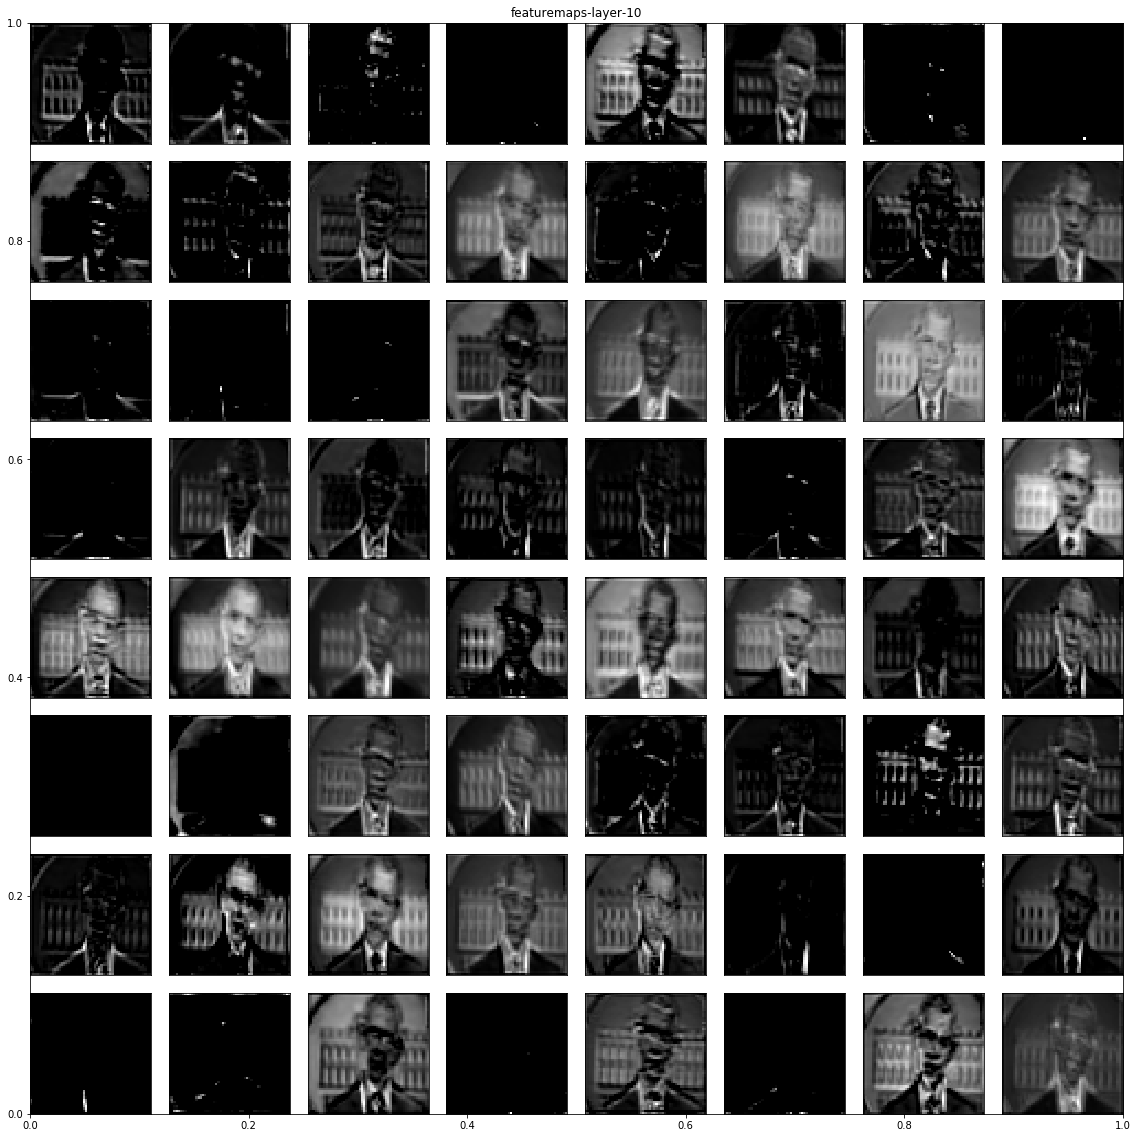

In [145]:
visualize_layer(custom_restnet_model, test_image_tensor, layer_num=10)

### Custom CNN Model

In this custom model, I use a sequence of 3 layers of convolutional and pooling. To reducing overfitting, I'm using a dropout. After that a fully connected layer and dropout again.
With this configuration, I get the better results.

In [112]:
import time
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, adam
from keras.callbacks import TensorBoard

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(100,100,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.5))
 
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(83, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 256)       295168    
__________

In [113]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint  
from time import time
### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 50
### Do NOT modify the code below this line.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.custom.model_{}.hdf5'.format("pc50-batch20-ada"), 
                               verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir="logs/custom_{}".format(time()))
#tensorboard = TensorBoard(log_dir="logs/vgg16_{}".format(time()),write_images=True,write_grads=True, histogram_freq=5.0)

trainning_result = model.fit(train_tensors, train_targets, 
           validation_data=(valid_tensors, valid_targets),
           epochs=epochs, batch_size=20, callbacks=[checkpointer,tensorboard], verbose=1)

#### Load weights trained on a GPU machine

In [114]:
model.load_weights('saved_models/weights.custom.model_pc.hdf5')

In [115]:
scores = model.evaluate(test_tensors, test_targets, batch_size=20)

print(scores)

1388/1388 [==============================] - 10s    
[0.89627926158973736, 0.7903458189208501]


### Testing the model

In [131]:
test_image_tensor = path_to_tensor('../obama.jpeg')
test_image = cv2.imread('../obama.jpeg')
print (test_image_tensor.shape)

(1, 100, 100, 3)


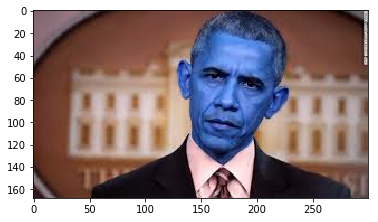

../faces/test/Barack Obama/210.jpg


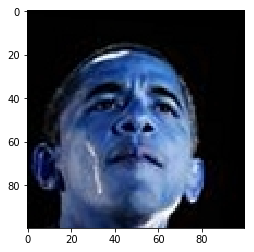

In [132]:
prediction_class = show_predictions(test_image_tensor, model)
compare_prediction(test_image, prediction_class)

#### Visualizing the model performance

In [17]:
import matplotlib.pyplot as plt                        
train_loss = trainning_result.history['loss']
validation_loss = trainning_result.history['val_loss']
train_acc = trainning_result.history['acc']
validation_acc = trainning_result.history['val_acc']
xc = range(50)

NameError: name 'trainning_result' is not defined

In [ ]:
visualize_loss(xc,train_loss, validation_loss)
visualize_acc(xc, train_acc, validation_acc)

#### Visualizing the layers

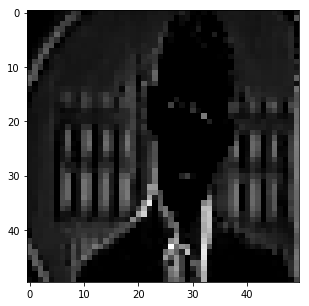

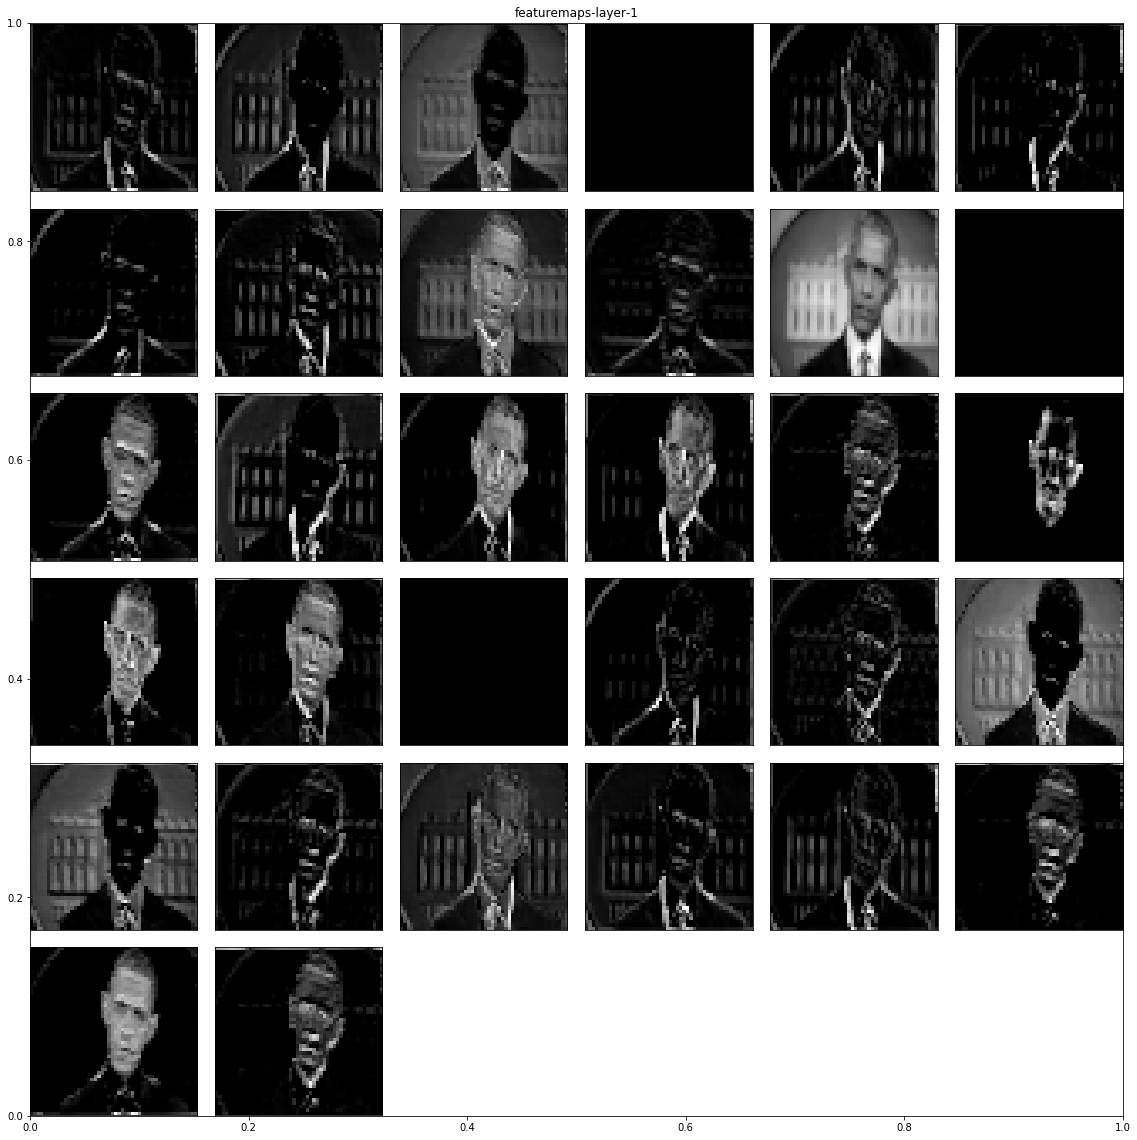

In [140]:
visualize_layer(model, test_image_tensor, layer_num=1)